## This notebook shows a general example mass balance calculations, we currentlt support two alghrithoms
1. [Non-negative alghrithom](https://epubs.siam.org/doi/pdf/10.1137/1.9781611971217.bm), it solves KKT (Karush-Kuhn-Tucker) conditions for the non-negative least squares problem
2. Matrix decomposition, following [Li et al. (2020)](https://www.sciencedirect.com/science/article/pii/S0009281920300301?casa_token=sT59EIzD3QkAAAAA:bQSW0-dssOb6YRtOMb-69ctkXC0BzW5_zlalxk4EV2GFwhm4apnk73tsq4TKVc4vipPyIImq8Twg) and [Ghiorso 1983](https://www.sciencedirect.com/science/article/pii/0098300483900080). The compositional matrix will be broken down by singular value decomposition, the coefficients will then calculated.

In [1]:
# import python modules
import pandas as pd
import matplotlib.pyplot as plt
from MassBalance.mb_tools import MassBalance  # this is the core object of the mb calculation

### 1. Define elements for calculation

We first need to define element list for mass balance calculation, special attention goes to `FeO` term, which we use `FeO`, not ``FeOt`` nor ``FeOtot``, this is consistent with the input excel files. Feel free to change the order of the elements

In [2]:
cmpnts = ['SiO2','Al2O3', 'TiO2', 'MgO', 'FeO', 'MnO',  'CaO', 'Na2O', 'K2O', 'P2O5', 'Cr2O3']  # change your desired elements for mass balance calculation

if you also want to integrate standard deviation on elements, this can be done manually or by the following line

In [3]:
cmpnts_std =[x + '_std' for x in cmpnts]  # save columns for std
cmpnts_std

['SiO2_std',
 'Al2O3_std',
 'TiO2_std',
 'MgO_std',
 'FeO_std',
 'MnO_std',
 'CaO_std',
 'Na2O_std',
 'K2O_std',
 'P2O5_std',
 'Cr2O3_std']

### 2. Load data

The easist way is to copy paste data in the input excel file, please also check README file for details of data prepration

In [4]:
nat_comp = pd.ExcelFile("input_comp.xlsx")

We load the whole excel spreadsheet to a pandas ExcelFile, to access data in your spreadsheet, you can do so by looping through ExcelFile to a dictionary:

In [5]:
nat_dict = {}  # create dictionary to collect compositions of different phases
nat_phases = []  # create list to save all phases in the calculation. Note bulk will be the bulk compsition, run_index will be your sample number, or rock id . etc
for sheet_name in nat_comp.sheet_names:
    nat_phases.append(sheet_name)
    nat_dict[sheet_name] = nat_comp.parse(sheet_name)

``nat_phases`` stores the sheet names, ``nat_dict`` stores the data of each sheet. 

In [6]:
nat_phases

['gl', 'ol', 'sp', 'py', 'pureFe', 'pureNa', 'bulk', 'run_index']

Use the sheet name to access data, let's what we have in the ``gl`` phase


In [7]:
nat_dict['gl'].head()

,Run_no,SiO2,Al2O3,P2O5,CaO,FeO,Na2O,MgO,TiO2,K2O,...,Al2O3_std,P2O5_std,CaO_std,FeO_std,Na2O_std,MgO_std,TiO2_std,K2O_std,MnO_std,Cr2O3_std
0,02As1,46.66,10.16,0.17,11.64,13.06,1.95,13.15,2.43,0.49,...,0.17,0.10,0.22,0.34,0.10,0.26,0.20,0.04,0.04,0.04
1,01As1,46.96,10.34,0.20,11.81,13.21,1.84,12.16,2.53,0.44,...,0.11,0.07,0.20,0.21,0.10,0.12,0.14,0.05,0.03,0.08
2,04As1,47.20,10.80,0.23,12.13,12.77,1.87,11.04,2.65,0.48,...,0.11,0.05,0.21,0.45,0.14,0.09,0.16,0.05,0.05,0.03
3,03As1,48.38,11.36,0.18,12.63,13.03,1.42,10.35,2.54,0.43,...,0.16,0.06,0.12,0.27,0.07,0.19,0.27,0.05,0.05,0.05
4,05As1,47.18,11.63,0.23,12.84,12.57,2.04,9.42,2.60,0.51,...,0.12,0.05,0.25,0.20,0.12,0.18,0.23,0.05,0.04,0.05


### 3. Mass balance calculation

``MassBalance`` class does the core calculation.
To start the calculation, we need to define the ``MassBalance`` class by passing all necessary infos for calculations:
1. `input_comp` -- load the ExcelFile variable
2. `comp_col` -- load element list
3. `comp_std_col` -- load element std list (if avaiable), default is ``None``
4. `match_column` -- this is the column name that saves your expts run no., sample no., or rock id. in each spreadsheet
5. `bulk_sheet` -- sheet name of which saves bulk composition(s)
6. `index_sheet` -- sheet name stores entire infos about expts run numbers ± condition, sample numbers or rock id.
7. `normalize` -- normalize your data to 100 during calculation, default is ``True``

In [8]:
mb_cal = MassBalance(
    input_comp=nat_comp,
    comp_col=cmpnts,
    comp_std_col=cmpnts_std,
    match_column="Run_no",
    bulk_sheet="bulk",
    index_sheet="run_index",
    normalize=True,
)

``mb_cal`` is variable we create for mass balance calculation
The calculation is done by calling the compute method in the `MassBalance` class as `mb_cal.compute()`
Four parameters can be tuned during computing:
1. `mc` -- define the number of MC calculations, the default is None, which will be a one time calculation
2. `exportFiles` -- we can export the results to excel file `output.xlsx` and `output_mean_median_std.xlsx`. If `mc` is given, `output_mean_median_std.xlsx`stores statistical infos for mc results
3. `batch_bulk`: define if you have different bulk for each group of phases, this is useful for layers in layered intrusions or expts with variable starting compositions for different runs. If you only have one bulk composition, can turn it to `False`
4. `method`: use `nnl` for non-negative method, `svd` for matrix decomposition method

Below we give examples to perform 100 times MC calculation with non-negative method, export files, and we have pre-defined a batch bulk composition in the input file. More examples are given in the python scipt along with this code

In [9]:
res_dict = mb_cal.compute(mc=100, exportFiles=True, batch_bulk=True, method='nnl')

The result is saved in a python dictionary, with each key responses to the expts run no., sample no, or rock id you defined in the index sheet
Let's take a look the results of first experimental run `02As1`

In [10]:
res_02As1 = res_dict['02As1']
res_02As1

,gl,ol,sp,py,pureFe,pureNa,r2,residues
0,0.972856,0.021906,0.0,0.0,0.0,0.000158,0.703634,0.495101
1,0.983275,0.012069,0.0,0.0,0.0,0.000075,0.704760,0.496686
2,0.987853,0.017529,0.0,0.0,0.0,0.000668,0.855129,0.731245
3,0.964934,0.029281,0.0,0.0,0.0,0.000205,0.674667,0.455176
4,0.979656,0.026223,0.0,0.0,0.0,0.000130,0.875085,0.765774
...,...,...,...,...,...,...,...,...
95,0.975669,0.032786,0.0,0.0,0.0,0.001784,0.558486,0.311906
96,0.984592,0.027391,0.0,0.0,0.0,0.000174,0.767013,0.588309
97,0.984631,0.015275,0.0,0.0,0.0,0.000560,0.591091,0.349388
98,0.983975,0.023029,0.0,0.0,0.0,0.000000,1.128175,1.272778


This is the MC results (100 times), to calculate statistical infos, you can simply call the built-in pandas functions as:

In [11]:
res_02As1.describe()

,gl,ol,sp,py,pureFe,pureNa,r2,residues
count,100.000000,100.000000,100.0,100.0,100.0,100.000000,100.000000,100.000000
mean,0.980573,0.020721,0.0,0.0,0.0,0.000708,0.819810,0.737976
std,0.009371,0.007229,0.0,0.0,0.0,0.000756,0.257979,0.444507
min,0.954178,0.000035,0.0,0.0,0.0,0.000000,0.304618,0.092792
25%,0.975013,0.015463,0.0,0.0,0.0,0.000000,0.602213,0.362675
50%,0.981619,0.020839,0.0,0.0,0.0,0.000506,0.818477,0.669904
75%,0.986480,0.025259,0.0,0.0,0.0,0.001208,1.020251,1.040923
max,1.010885,0.041295,0.0,0.0,0.0,0.002939,1.566041,2.452484


or only interested parameters

In [12]:
res_02As1.agg(['mean', 'median', 'std'])

,gl,ol,sp,py,pureFe,pureNa,r2,residues
mean,0.980573,0.020721,0.0,0.0,0.0,0.000708,0.819810,0.737976
median,0.981619,0.020839,0.0,0.0,0.0,0.000506,0.818477,0.669904
std,0.009371,0.007229,0.0,0.0,0.0,0.000756,0.257979,0.444507


To plot the result, you can simply do:

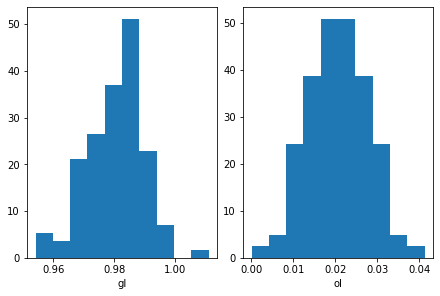

In [13]:
fig, axes = plt.subplots(1,2, constrained_layout=True)
axes[0].hist(res_02As1['gl'], density=True)
axes[1].hist(res_02As1['ol'], density=True)
axes[0].set_xlabel('gl')
axes[1].set_xlabel('ol')
plt.show()

We pre-defined pure FeO and pure Na2O phases as the evaluation of Fe loss and Na loss, if you don't want to check this, simply delete these sheets
Below we give an example to calculate Fe loss (%) and Na loss (%) in the first experimental run `02As1`


In [14]:
nat_bulk = nat_dict['bulk'].set_index('Run_no')
nat_bulk.loc['02As1', 'FeO']

12.42

In [15]:
nat_bulk.loc['02As1', 'Na2O']

1.96

In [16]:
res_02As1['Fe_loss'] = res_02As1['pureFe'] / nat_bulk.loc['02As1', 'FeO'] * 100 * 100
res_02As1['Fe_loss'].agg(['mean', 'median', 'std'])

mean      0.0
median    0.0
std       0.0
Name: Fe_loss, dtype: float64

In [17]:
res_02As1['Na2O_loss'] = res_02As1['pureNa'] / nat_bulk.loc['02As1', 'Na2O'] * 100 * 100
res_02As1['Na2O_loss'].agg(['mean', 'median', 'std'])

mean      3.610424
median    2.581412
std       3.857087
Name: Na2O_loss, dtype: float64

# Fin ~ happy coding!